# Can we find unique clients in data?
Transactions in data looks like are independent of each other. Perhaps the organizers made it for better data anonymization. But what if we find transactions belonging to the same user? May be it will help someone in this competition.

I accidentally saw some magic in the feature V307

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import sys, gc, warnings, random, math, time, datetime 
from tqdm import tqdm
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from scipy.stats.stats import pearsonr
import hashlib
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

import os
print(os.listdir("../input/features/"))

['train_y.pkl', 'train_uid_features.pkl', 'train_features.pkl', 'useful_features.npy', 'test_features.pkl', 'test_uid_features.pkl', 'train_basic_features.pkl', 'rm_features.npy', 'test.pkl', 'test_basic_features.pkl', 'train.pkl']


In [2]:
train = pd.read_pickle('../input/features/train.pkl')
test = pd.read_pickle('../input/features/test.pkl')
train_y = train['isFraud'].copy()

train= train.reset_index()
test = test.reset_index()

print(train.shape)
print(train_y.shape)
print(test.shape)

(590540, 434)
(590540,)
(506691, 434)


In [3]:
train['card1'] = train['card1'].fillna(0)
train['card2'] = train['card2'].fillna(0)
train['card3'] = train['card3'].fillna(0)
train['card5'] = train['card5'].fillna(0)
train['card4'] = train['card4'].fillna('nan')
train['card6'] = train['card6'].fillna('nan')

In [4]:
test['card1'] = test['card1'].fillna(0)
test['card2'] = test['card2'].fillna(0)
test['card3'] = test['card3'].fillna(0)
test['card5'] = test['card5'].fillna(0)
test['card4'] = test['card4'].fillna('nan')
test['card6'] = test['card6'].fillna('nan')

### Functions that will help us find unique devices and unique cards. (I think it is clear for you why we use hash functions)

In [5]:
def card_info_hash(x):
    s = (str(int(x['card1']))+
         str(int(x['card2']))+
         str(int(x['card3']))+
         str(x['card4'])+
         str(int(x['card5']))+
         str(x['card6']))
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [6]:
def device_hash(x):
#     s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])
    
    s = str(x['id_19'])+str(x['id_20'])
    
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h


In [7]:
train['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1   )
train['device_hash'] = train.apply(lambda x: device_hash(x), axis=1   )

In [8]:
test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1   )
test['device_hash'] = test.apply(lambda x: device_hash(x), axis=1   )

In [9]:
def get_data_by_card_hash( data, card_hash):
    mask = data['card_hash']==card_hash
    return data.loc[mask,:].copy()


def get_data_by_device_hash( data, device_hash):
    mask = data['device_hash']==device_hash
    return data.loc[mask,:].copy()


def get_data_by_card_and_device_hash( data, card_hash, device_hash):
    mask = (data['card_hash']==card_hash) &(data['device_hash']==device_hash)
    return data.loc[mask,:].copy()

In [10]:
s = train.groupby(['card_hash' , 'device_hash'])['isFraud'].agg(['mean', 'count'])

In [11]:
s[(s['mean']<0.11) & (s['count']>15) ].head(500)

mean  count
card_hash       device_hash                     
00007de9da93a93 50d04d3b25f61a1  0.000000     52
0019f3763312db0 50d04d3b25f61a1  0.000000    150
001ae896a9acf23 50d04d3b25f61a1  0.000000     32
00568a5c38f757a 50d04d3b25f61a1  0.000000     35
005f1a126e32e46 50d04d3b25f61a1  0.020000     50
0084e8d70fb2a12 50d04d3b25f61a1  0.023810     84
0089e971022bd9f 050ed7bf008c36a  0.086957     46
                124b4954b0d5f8e  0.000000     26
                1313458633d6465  0.000000     22
                141ce61ab28853d  0.069820    444
                1492f6293347c55  0.000000     16
                1bfebe9b2046485  0.000000     22
                407e535686a8406  0.000000     25
                44b9245bfa49a66  0.097561     41
                44d14f5d51448bd  0.039216     51
                4ce509b9cd5b29a  0.090909     22
                50d04d3b25f61a1  0.028139    462
                5246fa1ab9e9c75  0.000000     27
                52d9d628b45146d  0.015267    131
                5592f4a8246db67  0.000000     19
                5d73f71bc4b2fb8  0.086420    162
                621d51fa0641905  0.105263     38
                687c98cfb333e86  0.057143     35
                75fc66c94bbc14c  0.102439    410
                7e104f956ac7485  0.000000     22
                861baa10af8395c  0.076087    184
                87ca17ec83fdd48  0.000000     20
                8fcd927a7f47ac2  0.054054     37
                8fd2430009b622f  0.042254     71
                90f922f8cfb154a  0.029412     34
                926701c021f30eb  0.075472    159
                935767701d014f5  0.053333     75
                9a95b4b058a13dc  0.016129     62
                9c4b5ba3e9e2c59  0.025735    272
                9d00aaf79f0778b  0.019231    104
                a112c837272b286  0.027778     36
                ac8fec850672237  0.043478     69
                afdc4c7c11e0e19  0.000000     24
                b0fd2bb5d4ea1fb  0.045455     22
                b65852c66407e73  0.000000     61
                b6b963377efc68b  0.000000     19
                c4065c11208206e  0.000000     38
                d28144a918093a9  0.018519    162
                e08764d36ca6d92  0.000000     21
                e101663ef2d6d0f  0.062500     16
                ef569fbfd827e02  0.052632     19
                fed9172cc1fd01d  0.047904    167
00b4b49b25ff179 50d04d3b25f61a1  0.000000    141
00b5913eda5dab1 50d04d3b25f61a1  0.000000     33
00bca075e934504 50d04d3b25f61a1  0.000000     16
00edb83c15b8491 50d04d3b25f61a1  0.000000    202
00ffe0f17ed5f3e 50d04d3b25f61a1  0.012195     82
010efea14145b78 50d04d3b25f61a1  0.000000     71
01120c90d8ac65b 50d04d3b25f61a1  0.000000     17
012329037bbf8fb 50d04d3b25f61a1  0.000000     33
0127340322320a7 50d04d3b25f61a1  0.037313    804
013e1c10efcb43d 50d04d3b25f61a1  0.000000     41
014ab3e18e32211 50d04d3b25f61a1  0.000000     29
015d1e74200d0f4 50d04d3b25f61a1  0.000000     26
0171bda54b6e02d 50d04d3b25f61a1  0.017172    990
018d8f26d2ead7b 50d04d3b25f61a1  0.044444     45
01a14305d3d5304 50d04d3b25f61a1  0.000000     47
01a708d9e6a6bab 50d04d3b25f61a1  0.007215    693
01b37735db7aa99 50d04d3b25f61a1  0.000000     66
02089e4201c478a 07a673f707795b5  0.000000     18
                1eb01a6f9cf1d53  0.000000     25
                2857b028a0dd3ec  0.000000     33
                2b59fe566cf9e34  0.000000    135
                2e39a2526adebf2  0.031250     64
                3fa1bb538f6762c  0.000000     17
                50d04d3b25f61a1  0.027126   9253
                54e4b2454551bc4  0.000000     30
                636c6390761b257  0.000000     32
                8fd2430009b622f  0.000000     20
                a1a91175fdb8403  0.000000     16
                a8c21c70a9d963e  0.000000     32
                b0f180061882560  0.041667     24
                b3e4d8a70a87e22  0.062500     32
                b98f70707d68492  0.000000     34
                fb2482c5b1faa96  0.000000     75
02182203096e6e4 50d

In [12]:
get_data_by_card_and_device_hash(train, '0084e8d70fb2a12', '50d04d3b25f61a1')

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_hash,device_hash
58310,3045310,0,1353719,107.937500,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,1.0,486.0,486.0,40.0,486.0,40.0,NaN,NaN,NaN,NaN,486.0,NaN,NaN,NaN,NaN,486.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0084e8d70fb2a12,50d04d3b25f61a1
108144,3095144,0,2141117,554.000000,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,58.0,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,F,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0084e8d70fb2a12,50d04d3b25f61a1
139778,3126778,0,2852751,92.000000,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0084e8d70fb2a12,50d04d3b25f61a1
149742,3136742,0,3090140,945.000000,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,1758.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0084e8d70fb2a12,50d04d3b25f61a1
157628,3144628,0,3279584,922.000000,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,18.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,F,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0084e8d70fb2a12,50d04d3b25f61a1
178030,3165030,0,3879315,108.500000,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0084e8d70fb2a12,50d04d3b25f61a1
178240,3165240,0,3882759,59.000000,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0084e8d70fb2a12,50d04d3b25f61a1
178307,3165307,0,3884030,59.000000,W,4999,249.0,150.0,visa,226.0,debit,299.0,87.0,5.0,NaN,NaN,NaN,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,11.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN

In [13]:
very_strange_thing = get_data_by_card_and_device_hash(train, '00edb83c15b8491', '50d04d3b25f61a1')

#magic
very_strange_thing['V307_diff'] = very_strange_thing['V307'].diff().shift(-1)
very_strange_thing['difference'] = very_strange_thing['V307_diff'] - very_strange_thing['TransactionAmt']

very_strange_thing[[ 'TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'device_hash','card_hash', 'V307', 'V307_diff', 'difference']]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,device_hash,card_hash,V307,V307_diff,difference
6,2987006,0,86522,159.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,45.950001,-113.050003
3600,2990600,0,157127,20.000000,W,50d04d3b25f61a1,00edb83c15b8491,45.950001,-45.950001,-65.949997
5697,2992697,0,180400,29.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,39.000000,10.000000
9312,2996312,0,266989,30.000000,W,50d04d3b25f61a1,00edb83c15b8491,39.000000,26.949997,-3.050003
14296,3001296,0,408891,20.000000,W,50d04d3b25f61a1,00edb83c15b8491,65.949997,625.549988,605.549988
21478,3008478,0,569765,92.000000,W,50d04d3b25f61a1,00edb83c15b8491,691.500000,-691.500000,-783.500000
25665,3012665,0,665685,87.937500,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,39.000000,-48.937500
27074,3014074,0,683332,24.000000,W,50d04d3b25f61a1,00edb83c15b8491,39.000000,-10.000000,-34.000000
27572,3014572,0,690860,15.000000,W,50d04d3b25f61a1,00edb83c15b8491,29.000000,-29.000000,-44.000000
27934,3014934,0,696732,77.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,44.000000,-33.000000


# Don't see anything?

> # Coincidence? i don't think so 

![](https://www.meme-arsenal.com/memes/06308418f56ad0d8d674c247e5ccba49.jpg )

### Highly likely V307 is a cumulative sum of transactions for a certain period for one unique client

This group of transactions has the same card hash and device hash, and 41 consecutively increasing numbers. Also all this transactions are fraud. 

May be this knowledge will help you to significantly improve your models. 

It doesn't work for all pairs of card and devices hashes, so you can improve alghoritm for searching unique clients.

# Bonus: You can try to decipher the values of some features

In [14]:
def dt_features(data):
    data = data.copy()
    
    start_dt = data['TransactionDT'].min()
    data['TransactionDT_norm']  = (data['TransactionDT'] - start_dt)/3600
    data['TransactionDT_norm_days'] = data['TransactionDT_norm']/24
    data['TransactionDT_diff'] = data['TransactionDT_norm'].diff().fillna(0)
    data['TransactionDT_diff_days'] = data['TransactionDT_diff']/24
    return data

In [15]:
very_strange_thing = dt_features(very_strange_thing)

In [16]:
list_of_interesting_features = [ 'TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'device_hash','card_hash', 'V307', 'V307_diff', 'difference', 
                                'TransactionDT_norm_days', 'TransactionDT_diff', 'TransactionDT_diff_days', 
                               
                               ] + ['D{}'.format(i) for i in range(1,16)]

In [24]:
very_strange_thing

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_hash,device_hash,V307_diff,difference,TransactionDT_norm,TransactionDT_norm_days,TransactionDT_diff,TransactionDT_diff_days
6,2987006,0,86522,159.000000,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00edb83c15b8491,50d04d3b25f61a1,45.950001,-113.050003,0.000000,0.000000,0.000000,0.000000
3600,2990600,0,157127,20.000000,W,12308,360.0,150.0,visa,166.0,debit,330.0,87.0,6.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,10.0,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,T,T,F,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00edb83c15b8491,50d04d3b25f61a1,-45.950001,-65.949997,19.612500,0.817188,19.612500,0.817188
5697,2992697,0,180400,29.000000,W,12308,360.0,150.0,visa,166.0,debit,327.0,87.0,1.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,47.0,47.0,47.0,0.0,NaN,NaN,NaN,NaN,NaN,47.0,0.0,NaN,NaN,NaN,47.0,T,T,F,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00edb83c15b8491,50d04d3b25f61a1,39.000000,10.000000,26.077222,1.086551,6.464722,0.269363
9312,2996312,0,266989,30.000000,W,12308,360.0,150.0,visa,166.0,debit,387.0,87.0,3.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,2.0,399.0,399.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,399.0,NaN,NaN,NaN,NaN,399.0,T,T,F,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00edb83c15b8491,50d04d3b25f61a1,26.949997,-3.050003,50.129722,2.088738,24.052500,1.002188
14296,3001296,0,408891,20.000000,W,12308,360.0,150.0,visa,166.0,debit,330.0,87.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,13.0,13.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00edb83c15b8491,50d04d3b25f61a1,625.549988,605.549988,89.546944,3.731123,39.417222,1.642384
21478,3008478,0,569765,92.000000,W,12308,360.0,150.0,visa,166.0,debit,184.0,87.0,14.0,NaN,aol.com,NaN,10.0,6.0,0.0,0.0,2.0,6.0,0.0,0.0,4.0,0.0,5.0,0.0,89.0,10.0,152.0,152.0,26.0,152.0,26.0,NaN,NaN,NaN,NaN,152.0,150.0,NaN,NaN,NaN,152.0,T,T,T,M0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00edb83c15b8491,50d04d3b25f61a1,-691.500000,-783.500000,134.234167,5.593090,44.687222,1.861968
25665,3012665,0,665685,87.937500,W,12308,360.0,150.0,visa,166.0,debit,433.0,87.0,2.0,NaN,aol.com,NaN,119.0,112.0,0.0,0.0,139.0,119.0,0.0,0.0,45.0,0.0,111.0,0.0,209.0,76.0,0.0,NaN,NaN,85.0,0.0,NaN,NaN,NaN,NaN,85.0,85.0,NaN,NaN,NaN,85.0,T,T,T,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [17]:
very_strange_thing[list_of_interesting_features]

# look at  TransactionDT_norm_days and  D8	D9
# D1 looks like  TransactionDT_norm_days rounded to int

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,device_hash,card_hash,V307,V307_diff,difference,TransactionDT_norm_days,TransactionDT_diff,TransactionDT_diff_days,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
6,2987006,0,86522,159.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,45.950001,-113.050003,0.000000,0.000000,0.000000,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0
3600,2990600,0,157127,20.000000,W,50d04d3b25f61a1,00edb83c15b8491,45.950001,-45.950001,-65.949997,0.817188,19.612500,0.817188,10.0,10.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN
5697,2992697,0,180400,29.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,39.000000,10.000000,1.086551,6.464722,0.269363,47.0,47.0,47.0,0.0,NaN,NaN,NaN,NaN,NaN,47.0,0.0,NaN,NaN,NaN,47.0
9312,2996312,0,266989,30.000000,W,50d04d3b25f61a1,00edb83c15b8491,39.000000,26.949997,-3.050003,2.088738,24.052500,1.002188,399.0,399.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,399.0,NaN,NaN,NaN,NaN,399.0
14296,3001296,0,408891,20.000000,W,50d04d3b25f61a1,00edb83c15b8491,65.949997,625.549988,605.549988,3.731123,39.417222,1.642384,13.0,13.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN
21478,3008478,0,569765,92.000000,W,50d04d3b25f61a1,00edb83c15b8491,691.500000,-691.500000,-783.500000,5.593090,44.687222,1.861968,152.0,152.0,26.0,152.0,26.0,NaN,NaN,NaN,NaN,152.0,150.0,NaN,NaN,NaN,152.0
25665,3012665,0,665685,87.937500,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,39.000000,-48.937500,6.703275,26.644444,1.110185,0.0,NaN,NaN,85.0,0.0,NaN,NaN,NaN,NaN,85.0,85.0,NaN,NaN,NaN,85.0
27074,3014074,0,683332,24.000000,W,50d04d3b25f61a1,00edb83c15b8491,39.000000,-10.000000,-34.000000,6.907523,4.901944,0.204248,7.0,7.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN,7.0
27572,3014572,0,690860,15.000000,W,50d04d3b25f61a1,00edb83c15b8491,29.000000,-29.000000,-44.000000,6.994653,2.091111,0.087130,52.0,52.0,6.0,6.0,6.0,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,NaN,53.0
27934,3014934,0,696732,77.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,44.000000,-33.000000,7.062616,1.631111,0.067963,414.0,414.0,93.0,93.0,93.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,413.0


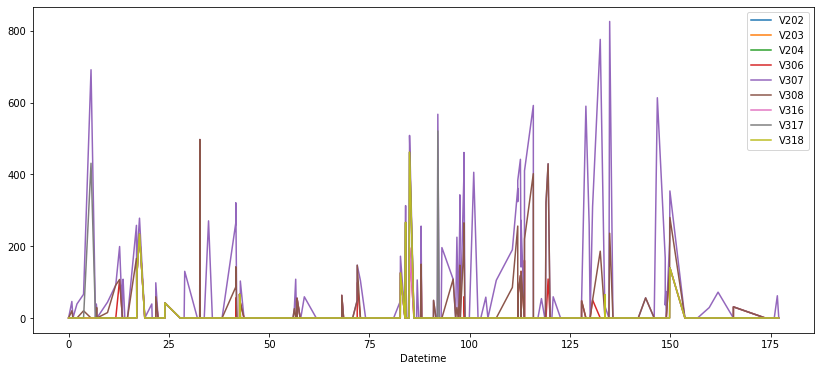

In [18]:
plt.figure(figsize=(14,6))
plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V202'] , label = 'V202' )
plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V203'] , label = 'V203')
plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V204'] , label = 'V204')

plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V306'] , label = 'V306')
plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V307'] , label = 'V307')
plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V308'] , label = 'V308')

plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V316'] , label = 'V316')
plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V317'] , label = 'V317')
plt.plot( very_strange_thing['TransactionDT_norm_days'], very_strange_thing['V318'] , label = 'V318')

plt.xlabel('Datetime')

plt.legend()
plt.show()

In [19]:
list_of_interesting_features = [ 'TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'device_hash','card_hash', 'V307', 'V307_diff', 'difference', 
                                'TransactionDT_norm_days', 'TransactionDT_diff', 'TransactionDT_diff_days', 
                               
                               ] + ['C{}'.format(i) for i in range(1,15)]

In [20]:
very_strange_thing[list_of_interesting_features]
# c2

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,device_hash,card_hash,V307,V307_diff,difference,TransactionDT_norm_days,TransactionDT_diff,TransactionDT_diff_days,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
6,2987006,0,86522,159.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,45.950001,-113.050003,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3600,2990600,0,157127,20.000000,W,50d04d3b25f61a1,00edb83c15b8491,45.950001,-45.950001,-65.949997,0.817188,19.612500,0.817188,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
5697,2992697,0,180400,29.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,39.000000,10.000000,1.086551,6.464722,0.269363,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0
9312,2996312,0,266989,30.000000,W,50d04d3b25f61a1,00edb83c15b8491,39.000000,26.949997,-3.050003,2.088738,24.052500,1.002188,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,2.0
14296,3001296,0,408891,20.000000,W,50d04d3b25f61a1,00edb83c15b8491,65.949997,625.549988,605.549988,3.731123,39.417222,1.642384,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0
21478,3008478,0,569765,92.000000,W,50d04d3b25f61a1,00edb83c15b8491,691.500000,-691.500000,-783.500000,5.593090,44.687222,1.861968,10.0,6.0,0.0,0.0,2.0,6.0,0.0,0.0,4.0,0.0,5.0,0.0,89.0,10.0
25665,3012665,0,665685,87.937500,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,39.000000,-48.937500,6.703275,26.644444,1.110185,119.0,112.0,0.0,0.0,139.0,119.0,0.0,0.0,45.0,0.0,111.0,0.0,209.0,76.0
27074,3014074,0,683332,24.000000,W,50d04d3b25f61a1,00edb83c15b8491,39.000000,-10.000000,-34.000000,6.907523,4.901944,0.204248,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0
27572,3014572,0,690860,15.000000,W,50d04d3b25f61a1,00edb83c15b8491,29.000000,-29.000000,-44.000000,6.994653,2.091111,0.087130,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,1.0
27934,3014934,0,696732,77.000000,W,50d04d3b25f61a1,00edb83c15b8491,0.000000,44.000000,-33.000000,7.062616,1.631111,0.067963,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


![](https://www.dictionary.com/e/wp-content/uploads/2018/04/another-one.jpg )

In [21]:
 s = get_data_by_card_and_device_hash(train, 'b4f15ed9e7c1e0a', 'b62aa9813bf1ea8')[[ 'TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'device_hash','card_hash', 'V307']]

In [22]:
#magic
s['V307_diff'] = s['V307'].diff().shift(-1)
s['difference'] = s['V307_diff'] - s['TransactionAmt']

In [23]:
s

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,device_hash,card_hash,V307,V307_diff,difference
